In [1]:
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
from IPython.display import Image

In [84]:
## Defining market impacts

def g(x, gamma=2.5*10**(-7), alpha=0.5):
    """
    Permanent market impact
    """
    return gamma * x ** alpha

def h(x, eta=2.5*10**(-6), epsilon=0.0625, beta=0.02):
    """
    Temporary market impact
    """
    return epsilon*np.sign(x) + eta*(x/tau)**beta

#g = g(5/1, gamma=2.5*10**(-7), alpha = 0.5)
#print(g)
#tau = 1
h_test = h(5/1, eta=2.5*10**(-6),epsilon=1/16,beta=0.02)
print(h_test)
h(x=5/1)
print(h_test)

0.06250258178104974
0.06250258178104974


In [3]:
# Defining moments expectation and varaince

def expectation_IS(N, tau=1.0, gamma=1.0, eta=1.0, eps=1.0):
    """
    Expectation of implementation shortfall.
    """
    exp = 0.5*gamma*X**2 + eps*np.sum(abs(N)) + (eta - 0.5*gamma*tau)/tau * np.sum(N**2)

    return exp

def variance_IS(N, sigma=0.3, tau=1.0):
    """
    Variance of implementation shortfall.
    """
    var = 0
    t = - 1
    while t < len(N) - 1:
        t = t + 1
        temp = (X - np.sum(N[0:t])) ** 2
        var = var + temp
    
    var = tau * (sigma**2) * var
    return var

# Objective function

def objective_IS(N):
    """
    Objective function for implementation shortfall.
    """
    obj = expectation_IS(N) + risk * variance_IS(N)
    return obj

In [26]:
# Defining the efficient frontier
def efficient_frontier(X, risk, nb_T, s0, v,sigma,benchmark='IS', tau=1.0, gamma=1.0, eta=1.0, eps=1.0, plot='False'):
    """
    Returns the optimal expectation and variance as well as the trading trajectory.
    It plots the trading trajectory.
    
    --------------------------------------------------------------------------
    Parameters:

    X, integer - Number of shares to be liquidated
    risk, float - Risk aversion coefficient
    nb_T, integer - Number of trading periods
    gamma, float - Parameter of the permanent market impact
    tau, float - Trading frequency
    eta, float - Parameter of the temporary market impact
    eps, float - Fixed cost of selling in the temporary market impact
        
    
    """
    V = np.sum(v)
    
    ########################################################################################################
    ############################################ MARKET IMPACT #############################################
    ########################################################################################################
    
    def g(x, gamma=2.5*10**(-7), alpha=0.02):
        """
        Permanent market impact
        """
        return gamma * x ** alpha

    def h(x, eta=2.5*10**(-6), epsilon=0.0625, beta=1.0):
        """
        Temporary market impact
        """
        return epsilon*np.sign(x) + eta*(x/tau)**beta

    ########################################################################################################
    ################################################## IS ##################################################
    ########################################################################################################
    
    def expectation_IS(n):
        """
        Returns the expectation of implementation shortfall.
        
        --------------------------------------------------------------------------
        Parameters:

        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        gamma, float - Parameter of the permanent market impact
        tau, float - Trading frequency
        eta, float - Parameter of the temporary market impact
        eps, float - Fixed cost of selling in the temporary market impact
        
        """
        
        exp = 0.5*gamma*X**2 + eps*np.sum(n) + (eta - 0.5*gamma)/tau * np.sum(n**2)
        return exp

    def variance_IS(n):
        """
        Returns the variance of implementation shortfall.
        
        --------------------------------------------------------------------------
        Parameters:

        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        gamma, float - Parameter of the permanent market impact
        tau, float - Trading frequency
        eta, float - Parameter of the temporary market impact
        eps, float - Fixed cost of selling in the temporary market impact
        sigma, array - Volatility of the stock
        
        """
        
        var = 0
        t = - 1
        while t < len(n) - 1:
            t = t + 1
            temp = (X - np.sum(n[0:t])) ** 2
            var = var + temp * sigma[t] **2
        var = tau * var
        return var
    
    def objective_IS(n):
        """
        Returns the objective function for implementation shortfall.
        """
        
        obj = expectation_IS(n) + risk * variance_IS(n)
        return obj
    
    ########################################################################################################
    ################################################## VWAP ################################################
    ########################################################################################################
    
    def expectation_VWAP(n):
        """
        Returns the expected VWAP.

        --------------------------------------------------------------------------
        Parameters:

        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        s0, float - Initial spot price
        gamma, float - Parameter of the permanent market impact
        tau, float - Trading frequency
        eta, float - Parameter of the temporary market impact
        eps, float - Fixed cost of selling in the temporary market impact
        v, array - Volume traded during the day
        """
        # s0=100, tau=1, gamma=1, eta=1, eps=1

        N = len(n)
        e = 0
        V = v.sum()
        # T = tau * N
        for k in range(N):
            gsum = 0
            for j in range(k):
                gsum+=g(n[j]/tau)
            e+=(X*v[k]/V - n[k])*(s0-gsum*tau) - X/V * tau*v[k]*g(n[k]/tau) + n[k]*h(n[k]/tau)
        return e

    def variance_VWAP(n):
        """
        Returns the VWAP variance
        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        s0, float - Initial spot price
        gamma, float - Parameter of the permanent market impact
        tau, float - Trading frequency
        eta, float - Parameter of the temporary market impact
        eps, float - Fixed cost of selling in the temporary market impact
        v, array - Volume traded during the day
        """
        # s0=100, X=1000, sigma=0.3, tau=1, gamma=1, eta=1, eps=1
        
        var = 0
        m = len(n)
        V = v.sum()
        for k in range(m):
            vsum = 0
            for j in range(k,m):
                vsum+=v[j]
            x = X - np.sum(n[0:k]) 
            var+=(X/V * vsum - x)**2 *sigma[k]**2
            # print(vsum*X/V, x)
        var = var*tau
        return var

    def objective_VWAP(n):
        """
        Objective function for VWAP.
        """
        obj = expectation_VWAP(n) + risk * variance_VWAP(n)
        return obj
    
    ########################################################################################################
    ################################################## TWAP ################################################
    ########################################################################################################
    
    def expectation_TWAP(n):
        """
        Returns the expected TWAP
        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        s0, float - Initial spot price
        gamma, float - Parameter of the permanent market impact
        tau, float - Trading frequency
        eta, float - Parameter of the temporary market impact
        eps, float - Fixed cost of selling in the temporary market impact
        """
        N = len(n)
        T = tau*N
        e = 0
        for k in range(N):
            sumg=0
            for j in range(k):
                sumg+=g(n[j]/tau)
            e+=(X*tau/T - n[k])*(s0-sumg*tau) - X/T * tau**2*g(n[k]/tau) + n[k]*h(n[k]/tau)
        return e

    def variance_TWAP(n):
        """
        Returns the TWAP variance
        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        s0, float - Initial spot price
        gamma, float - Parameter of the permanent market impact
        tau, float - Trading frequency
        eta, float - Parameter of the temporary market impact
        eps, float - Fixed cost of selling in the temporary market impact
        """
        var=0
        N = len(n)
        T = N * tau
        for k in range(N):
            tsum = 0
            for j in range(k,N):
                tsum+=tau
            x = X - np.sum(n[0:k])
            var+=(X/T * tsum-x)**2*sigma[k]**2*tau
        return var

    def objective_TWAP(n):
        return expectation_TWAP(n) + risk * variance_TWAP(n)
    
    ########################################################################################################
    ############################################ OPTIMIZATION ##############################################
    ########################################################################################################
    
    def optimization(benchmark):
        """
        Optimal execution with optimization for implementation shortfall.
        
        Returns the optimal trading trajectory.
        """
        
        x0  = np.ones((nb_T,1)) * X / nb_T
        bnds = tuple((0.0, X) for x in range(len(x0)))
        cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})
        
        if benchmark == "IS":
            opt = sco.minimize(objective_IS, x0, method='SLSQP', bounds=bnds, constraints=cons) 
            
        elif benchmark == "VWAP":
            opt = sco.minimize(objective_VWAP, x0, method='SLSQP', bounds=bnds, constraints=cons) 
            
        elif benchmark == "TWAP":
            opt = sco.minimize(objective_TWAP, x0, method='SLSQP', bounds=bnds, constraints=cons) 
            
        else:
            raise ValueError("Unknown benchmark: " + str(benchmark))
            
        n = np.array(opt.x)
        return n
    
    def liquidation_history(N_opt, X):
        """
        Prints out the liquidation history of the optimal execution.
        
        --------------------------------------------------------------------------
        Parameters:

        n, array - Trading trajectory
        X, integer - Number of shares to be liquidated
        
        """
        
        x_k=[X]
        for i in range(len(N_opt)):
            x_k.append(x_k[i] - N_opt[i])
        return x_k

    def plot_liquidation():
        plt.figure(figsize=(7,5))
        plt.plot(hist_opt, color='blue', lw=1.5)
        plt.grid(True)
        plt.xlabel('Time')
        plt.ylabel('Nb. of shares')
        plt.title("Liquidation path for "+benchmark+" and risk aversion of: " +str(risk))
        plt.show()
        
    N_opt = optimization(benchmark)
    hist_opt = liquidation_history(N_opt,X)
    
    if plot=='True':
        plot_liquidation()
    
    if benchmark == 'IS':
        ex=expectation_IS(N_opt)
        va=variance_IS(N_opt)
    elif benchmark == 'VWAP':
        ex=expectation_VWAP(N_opt)
        va=variance_VWAP(N_opt)
    elif benchmark == 'TWAP':
        ex=expectation_TWAP(N_opt)
        va=variance_TWAP(N_opt)
    else:
        raise ValueError("Unknown benchmark.")
        
    res = hist_opt, ex,va
    
    return res

In [36]:
# Parameters definition
_tau = 1
_gamma = 2.5*10**(-7)
_eta = 2.5*10**(-6)
_eps = 0.0625

# Variables definition
_s0 = 50      # spot
_X = 1e6      # Initial inventory
_nb_T = 5    # number of trading periods
_V = 5000000  # 
_cs = 0.3/np.sqrt(250)     # constant daily volatility
#_sigma = 0.9486832980505138
_sigma = [_cs * _s0 for t in range(_nb_T)]


# constant daily volume 
_v = np.ones((_nb_T,1)) * _V / _nb_T


#print('Risk aversion:', 2*10**(-6))
test = efficient_frontier(X=_X, risk=2*10**(-6), nb_T=_nb_T, s0=_s0,v = _v,sigma=_sigma,
                          benchmark='IS',
                             tau=_tau,
                             gamma=_gamma,
                             eta=_eta,
                             eps=_eps)

#print('Risk aversion:', 0)
test = efficient_frontier(X=_X, risk=0, nb_T=_nb_T, s0=_s0,v = _v,sigma=_sigma,
                          benchmark='IS',
                             tau=_tau,
                             gamma=_gamma,
                             eta=_eta,
                             eps=_eps)

#print('Risk aversion:', -2*10**(-7))
test = efficient_frontier(X=_X, risk=-2*10**(-7), nb_T=_nb_T, s0=_s0,v = _v,sigma=_sigma,
                          benchmark='IS',
                             tau=_tau,
                             gamma=_gamma,
                             eta=_eta,
                             eps=_eps)



C:\Users\jeope\AppData\Local\Temp\ipykernel_10636\4001730670.py:228: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  opt = sco.minimize(objective_IS, x0, method='SLSQP', bounds=bnds, constraints=cons)


In [35]:
print(efficient_frontier(X=_X, risk=-2*10**(-7), nb_T=_nb_T, s0=_s0,v = _v,sigma=_sigma,
                          benchmark='IS',
                             tau=_tau,
                             gamma=_gamma,
                             eta=_eta,
                             eps=_eps))

print(efficient_frontier(X=_X, risk=2*10**(-6), nb_T=_nb_T, s0=_s0,v = _v,sigma=_sigma,
                          benchmark='IS',
                             tau=_tau,
                             gamma=_gamma,
                             eta=_eta,
                             eps=_eps))

([1000000.0, 912461.9241544129, 750000.2992269415, 530916.7448778829, 275096.12403284176, 0.0], 717543.8682773757, 2477373911389.526)
([1000000.0, 424648.80585926515, 179267.5458185235, 79198.08551495486, 39461.40607676397, -9.458744898438454e-11], 1147928.773499554, 1098263700558.2568)


C:\Users\jeope\AppData\Local\Temp\ipykernel_10636\4001730670.py:228: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  opt = sco.minimize(objective_IS, x0, method='SLSQP', bounds=bnds, constraints=cons)


C:\Users\jeope\AppData\Local\Temp\ipykernel_10636\4001730670.py:228: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  opt = sco.minimize(objective_IS, x0, method='SLSQP', bounds=bnds, constraints=cons)


[1000000.0, 424648.80585926515, 179267.5458185235, 79198.08551495486, 39461.40607676397, -9.458744898438454e-11]
[1000000.0, 800000.0, 600000.0, 400000.0, 200000.0, 0.0]
[1000000.0, 912461.9241544129, 750000.2992269415, 530916.7448778829, 275096.12403284176, 0.0]


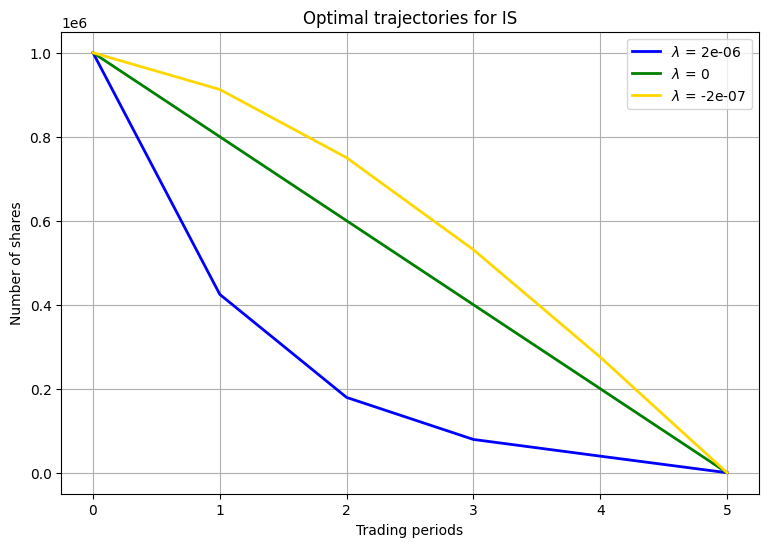

In [98]:
def comparison_ef(risks, X, nb_T, s0, v,sigma,benchmark='IS', tau=_tau, gamma=_gamma, eta=_eta, eps=_eps):
    
    """
    Plots the optimal trading trajectories for a list of risk aversion coefficients
    """
    
    N_opts = []

    for r in risks:
        temp = efficient_frontier(X, r, nb_T, s0, v,sigma,benchmark, tau, gamma, eta, eps,False)

        N_opts.append(temp[0])


    # Plotting
    print(N_opts[0])
    print(N_opts[1])
    print(N_opts[2])
    plt.figure(figsize=(9,6))
    plt.plot(N_opts[0], color='blue', lw=2.0, label='$\lambda$ = '+str(risks[0]))
    plt.plot(N_opts[1], color='green', lw=2.0, label='$\lambda$ = '+str(risks[1]))
    plt.plot(N_opts[2], color='gold', lw=2.0, label='$\lambda$ = '+str(risks[2]))
    #plt.plot(N_opts[3], color='darkorange', lw=2.0, label='$\lambda$ = '+str(risks[3]))
    #plt.plot(N_opts[4], color='crimson', lw=2.0, label='$\lambda$ = '+str(risks[4]))

    plt.grid(True)
    plt.title('Optimal trajectories for '+benchmark)
    plt.xlabel('Trading periods')
    plt.ylabel('Number of shares')
    plt.legend(loc='best')
    plt.savefig('liquidation_IS.png')
    plt.show()

#risks = [-1*10**(-7), 0.0, 1.0*10**(-7), 2.5*10**(-7), 9.0*10**(-7)]
risks = [2*10**(-6), 0, -2*10**(-7)]
comparison_ef(risks,_X, _nb_T, _s0, _v,_sigma,benchmark='IS', tau=_tau, gamma=_gamma, eta=_eta, eps=_eps)

C:\Users\jeope\AppData\Local\Temp\ipykernel_3392\374437992.py:228: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  opt = sco.minimize(objective_IS, x0, method='SLSQP', bounds=bnds, constraints=cons)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


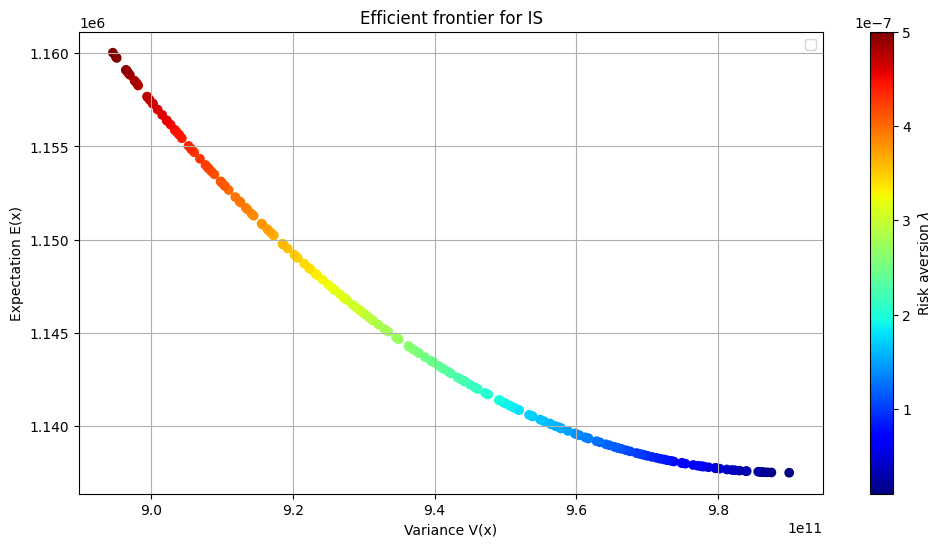

In [282]:
def frontier_efficient(risks,X, nb_T, s0, v,sigma,benchmark='IS', tau=1.0, gamma=1.0, eta=1.0, eps=1.0):
    
    """
    Plots the efficient frontier for a given benchmark
    """
    
    #risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 200)
    #risks = [10**(-6),0,-2*10**(-7)]

    x = []
    y = []

    for r in risks:
        temp = efficient_frontier(X, r, nb_T, s0, v,sigma,benchmark, tau, gamma, eta, eps,False)
        x.append(temp[2])  # V(x)
        y.append(temp[1])  # E(x)

    # Plotting
    plt.figure(figsize=(12,6))

    # Optimal strategies
    plt.scatter(np.ravel(x), np.ravel(y), marker='o', cmap='jet', c=risks)
    #plt.plot(x_naive, y_naive, "ro", lw=2, markersize=10, label='Minimum impact', markeredgecolor='red')
    plt.grid(True)

    plt.xlabel('Variance V(x)')
    plt.ylabel('Expectation E(x)')
    plt.title('Efficient frontier for '+benchmark)
    plt.colorbar(label='Risk aversion $\lambda$')
    plt.legend(loc='best')
    plt.savefig('efficient_frontier_IS.png')
    plt.show()
    
risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 200)
#risks = [10**(-6),0,-2*10**(-7)]
frontier_efficient(risks, 1e6, 5, 50, _v,_sigma,benchmark='IS', tau=0.5, gamma=2.5*10**(-7), eta=2.5*10**(-6), eps=0.0625)